In [4]:
import numpy as np
import pandas as pd
from glob import glob
import warnings

warnings.filterwarnings('ignore')

In [75]:
files = [file for file in glob('clean/feats_*')]
cols = ['teamId','teamName']

df = pd.DataFrame()
for file in files:
    if df.shape[0] == 0:
        df = pd.read_csv(file)
    else:
        df = pd.merge(df, pd.read_csv(file), on = cols)
        


df.head(2)

,teamId,teamName,betweennes,center_side,forward_position,shot_distance,long_short_passes,recovery_time,recovery_distance,one_touch,...,defense_line,defending_attackers,defense_variance,fouls_side_center,attacking_tackles,avg_chain_length,avg_chain_players,possesso,pass_dist,attacking_defenders
0,1609,Arsenal,7.285386,0.317708,659.156252,14.550186,0.090422,7.345825,0.783820,-1.121964,...,35.920419,23.947368,481.803278,0.739011,69.973069,4.133464,3.609002,60.97,23.062594,137.342105
1,1631,Leicester City,8.530305,0.270270,726.319416,15.096000,0.173541,7.795853,-0.128222,-0.960219,...,33.494870,22.315789,496.225946,0.730659,69.441156,2.756963,2.918625,50.64,25.396924,91.921053


In [53]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df.iloc[:, 2:])

df.iloc[:, 2:] = scaler.transform(df.iloc[:, 2:])
df_tot = df.copy()

In [51]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

hopkins(df.iloc[:, 2:])

0.6599893869598182

## PCA Analysis

In [20]:
from sklearn.decomposition import PCA

N = 3

pca = PCA(n_components=N)
pca.fit(df.iloc[:, 2:])
print(pca.explained_variance_ratio_)
components = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns = ['PCA'+str(i) for i in range(N)])
components['COMP'] = df.columns[2:]
components['KIND'] = ['Attack']*5 + ['Transitions']*5 + ['Defense']*5 + ['Possess']*5
components

[0.41656188 0.15438633 0.08795994]


,PCA0,PCA1,PCA2,COMP,KIND
0,-0.058735,0.007883,0.030678,betweennes,Attack
1,0.068633,-0.077981,-0.051493,center_side,Attack
2,-0.031517,-0.100346,0.183686,forward_position,Attack
3,-0.071798,-0.036075,0.019243,shot_distance,Attack
4,-0.159392,0.115583,0.032355,long_short_passes,Attack
5,-0.110584,-0.018091,-0.082336,recovery_time,Transitions
6,0.173041,0.078661,0.044378,recovery_distance,Transitions
7,0.115151,0.109222,0.038117,one_touch,Transitions
8,0.151145,0.088977,0.033057,counterattacks,Transitions
9,-0.154108,0.085699,0.003065,recovery_launch,Transitions


## PCA Analysis [One feature per time]


In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler





features = ['attacco','difesa','possesso','transizione']
N = 4

for feature in features:
    print('\n************************************\n')
    df = pd.read_csv('clean/feats_' + feature + '.csv')
    cols = [c for c in df.columns if 'team' not in c]
    
    
    scaler = MinMaxScaler()
    scaler.fit(df.loc[:, cols])
    df.loc[:, cols] = scaler.transform(df.loc[:, cols])
    
    pca = PCA(n_components=N)
    pca.fit(df.loc[:, cols])
    
    print(pca.explained_variance_ratio_)
    print('\n')
    components = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), columns = ['PCA'+str(i+1) for i in range(N)])
    components['COMP'] = cols
    print(components)
    


************************************

[0.34527289 0.26404123 0.17110182 0.13920533]


       PCA1      PCA2      PCA3      PCA4               COMP
0 -0.106107 -0.003686  0.161657 -0.037551         betweennes
1  0.129157  0.040968  0.070008  0.045302        center_side
2 -0.072190  0.206380 -0.029136 -0.040769   forward_position
3 -0.080116  0.045383  0.012776  0.149439      shot_distance
4 -0.169077 -0.076013 -0.041586  0.004767  long_short_passes

************************************

[0.45380291 0.20663455 0.14904562 0.12590208]


       PCA1      PCA2      PCA3      PCA4                 COMP
0  0.127637  0.039786  0.120998  0.004147         defense_line
1 -0.093788  0.180519 -0.025810  0.018556  defending_attackers
2  0.141715  0.065108  0.024089 -0.032485     defense_variance
3 -0.023345  0.010583 -0.013802 -0.148464    fouls_side_center
4  0.198353  0.014483 -0.108900  0.011841    attacking_tackles

************************************

[0.76475009 0.13754944 0.0531333  0.0425029

## K-Means [all features together]

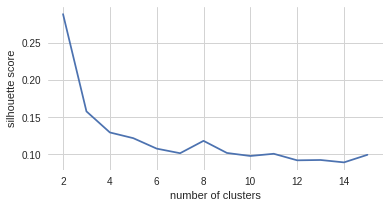

In [31]:
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn import cluster
import matplotlib.pyplot as plt 


sils = []
cols_pos = df.columns[2:]
Sum_of_squared_distances = []

for k in range(2,16):
    model = cluster.KMeans(n_clusters=k)
    model = model.fit(df[cols_pos])
    labels = model.labels_
    sil = silhouette_score(df[cols_pos], labels=labels)
    sils.append((sil))
    Sum_of_squared_distances.append(model.inertia_)

plt.figure(figsize=(6, 3))
ax=plt.subplot(111)
plt.style.use(['seaborn'])
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgrey'
ax.set_xlabel('number of clusters')
ax.set_ylabel('silhouette score')
_fontsize = 21

plt.plot(list(range(2,16)),sils)
plt.show();

## K-Means [one feature per time]

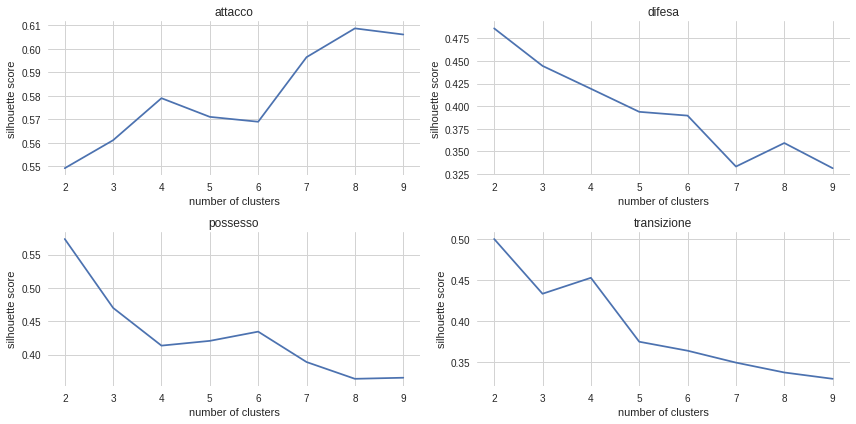

In [47]:
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn import cluster
import matplotlib.pyplot as plt 


features = ['attacco','difesa','possesso','transizione']
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12, 6))


for i in range(len(features)):
    feature = features[i]
    df = pd.read_csv('clean/feats_' + feature + '.csv')
    
    plt.subplot(2,2,i+1)
    ax = plt.gca()
    
    sils = []
    cols_pos = [c for c in df.columns if 'team' not in c]

    Sum_of_squared_distances = []

    for k in range(2,10):
        model = cluster.KMeans(n_clusters=k)
        model = model.fit(df[cols_pos])
        labels = model.labels_
        sil = silhouette_score(df[cols_pos], labels=labels)
        sils.append((sil))
        Sum_of_squared_distances.append(model.inertia_)


    plt.style.use(['seaborn'])
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['grid.color'] = 'lightgrey'
    ax.set_xlabel('number of clusters')
    ax.set_ylabel('silhouette score')
    plt.title(feature)
    _fontsize = 21

    plt.plot(list(range(2,10)),sils)
    
    
fig.tight_layout()
plt.show();

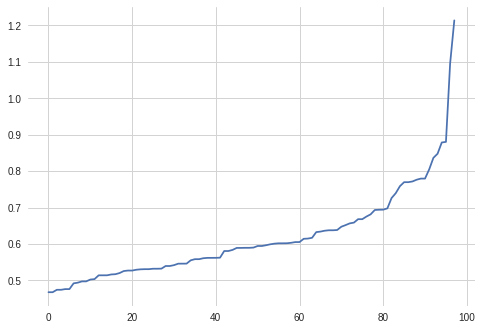

In [98]:
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


X = df.iloc[:, 2:]
# scaler = StandardScaler()
scaler = MinMaxScaler()

scaler.fit(X)
X = scaler.transform(X)

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);

In [99]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler



# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps = .7).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

x = df[['teamId','teamName']]
x['Cluster'] = labels
print(labels)

[ 0  0 -1  0 -1  0 -1  0  0  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0 -1  0 -1  0  0  0  0  0  0
  0  0  0 -1  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0  0 -1  0 -1  0
 -1  0  0  0  0  0 -1  0 -1  0  0 -1 -1 -1  0 -1  0  0  0  0  0 -1  0  0
  0  0]
